# Dataworth with Freyberg Pilot Points Model

### Here we are going to investigate the sources of forecast uncertainty as well as the worth of observations to reduce forecast uncertainty.  This is essentially the same workflow as used with the ``freyberg_zone_dataworth`` excersize.  Important things to remember:
### - FOSM doesn't require values for observations, parameters or forecast.  We do need sensitivities between the quantities and estimates of prior uncertainties for parameters and observtion noise.  
- 

In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu

In [2]:
import freyberg_setup as fs
fs.setup_pest_pp()
working_dir = fs.WORKING_DIR_PP
pst_name = fs.PST_NAME_PP

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'obs_loc.csv', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_pp
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_pilot_points_dataworth/freyberg_pp/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GE

In [3]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
par = pst.parameter_data
par.loc[par.parnme.apply(lambda x: x.startswith("w")),"partrans"] = "fixed"
pst.control_data.noptmax = -1
pst.write(os.path.join(working_dir,pst_name))


In [4]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"pestpp",pst_name,num_slaves=15,master_dir=".")
os.chdir("..")

master:./pestpp freyberg_pp.pst /h :4004 in .
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_0
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_1
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_2
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_3
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_4
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_5
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_6
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_7
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_8
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_9
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_10
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_11
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_12
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_13
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_14


In [5]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace(".pst",".jcb")))

### A quick check of which parameters are being informed by the observations during calibration:

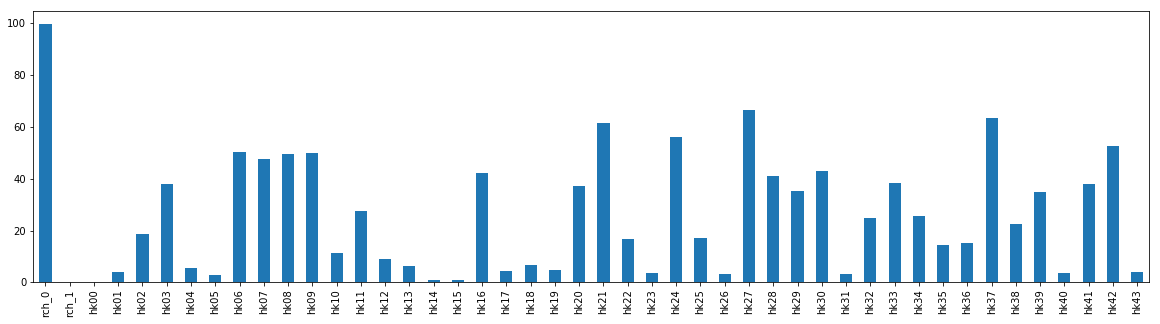

In [6]:
fig = plt.figure(figsize=(20,5))
ax = plt.subplot(111)
sc.get_parameter_summary().percent_reduction.plot(kind="bar",ax=ax)

## Parameter contribution analysis

### We are going to use the ``Schur.get_par_contribution()`` method. It calculates the *decrease* in forecast uncertainty resulting for hypothetical "perfect knowledge" (no uncertainty) of arbitrary groups of parameters. If you don't pass any arguments, then it tests each parameter independently:

In [7]:
df_pc = sc.get_par_contribution()


In [8]:
df_pc = 100.0 * (1.0 - df_pc / df_pc.loc["base",:])

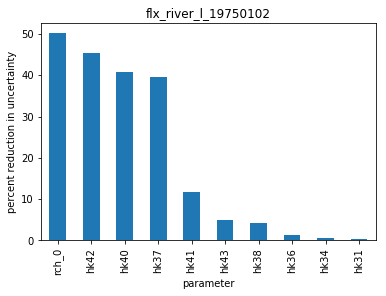

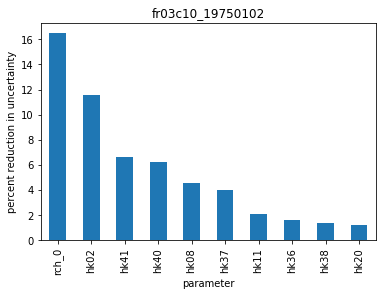

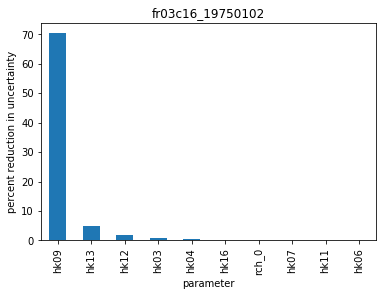

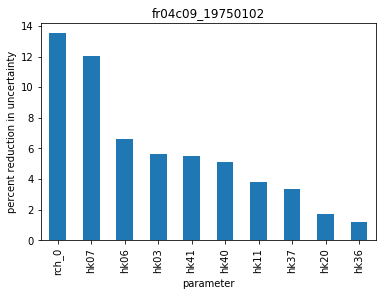

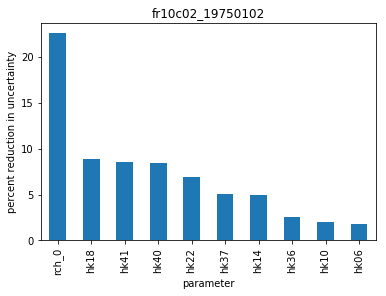

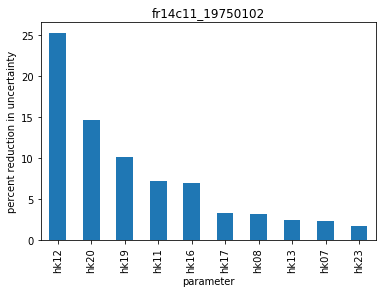

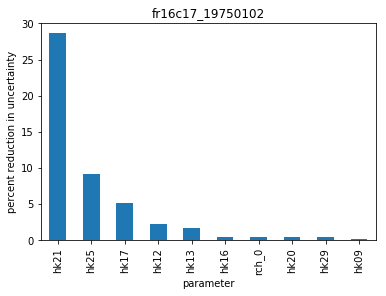

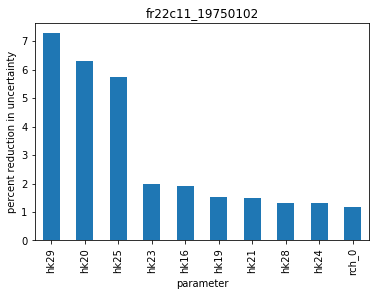

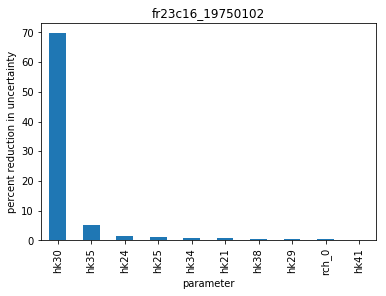

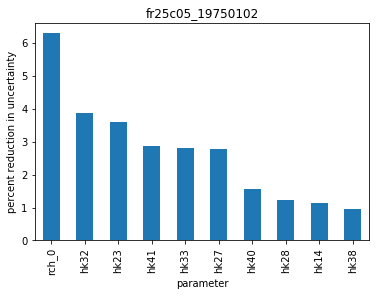

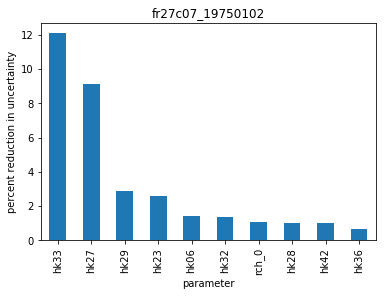

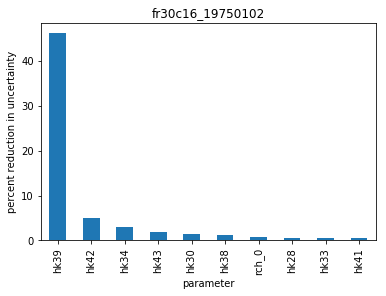

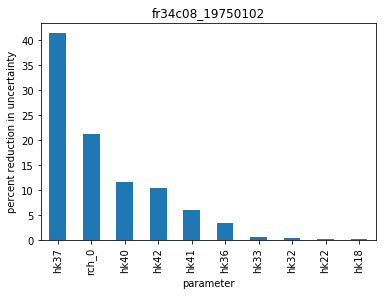

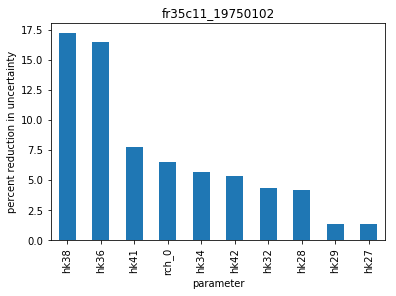

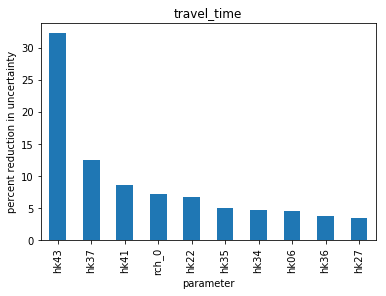

In [9]:
for forecast in df_pc.columns:
    ax = df_pc.sort_values(by=forecast,ascending=False).loc[:,forecast].iloc[:10].plot(kind="bar")
    ax.set_title(forecast)
    ax.set_ylabel("percent reduction in uncertainty")
    ax.set_xlabel("parameter")
    plt.show()

### We see a mixture of HK pilot points, recharge, and well pumping rates...so we see that each forecast depends on (potentailly) difference combinations of parameters.  Does this mean we can still make a model that makes several kinds of forecasts???

## Observation worth

### Let's see what observations are most important to the forecasts.  We will start be investigating the value of the existing observations using the ``Schur.get_removed_obs_importance()`` method.  It calculates the *increase* in forecast uncertainty that happens if we lose each existing observation. We will start with the existing observations:

In [10]:
df_rm = sc.get_removed_obs_importance()
df_rm

,flx_river_l_19750102,fr03c10_19750102,fr03c16_19750102,fr04c09_19750102,fr10c02_19750102,fr14c11_19750102,fr16c17_19750102,fr22c11_19750102,fr23c16_19750102,fr25c05_19750102,fr27c07_19750102,fr30c16_19750102,fr34c08_19750102,fr35c11_19750102,travel_time
base,1413.967267,0.018534,0.014244,0.029625,0.048232,0.034260,0.019310,0.018070,0.013464,0.033165,0.027499,0.014147,0.031076,0.031397,2.883926e+07
cr10c02_19700102,1414.243368,0.018672,0.014248,0.031857,2.116055,0.034330,0.019310,0.018227,0.013465,0.033450,0.028095,0.014147,0.031077,0.031460,2.897869e+07
cr16c17_19700102,1414.159114,0.018534,0.014257,0.029638,0.048239,0.034337,0.095827,0.019366,0.013475,0.033185,0.027521,0.014159,0.031077,0.031405,2.885393e+07
cr04c09_19700102,1414.004196,0.026668,0.014246,0.183781,0.048233,0.034723,0.019317,0.018070,0.013465,0.033174,0.027536,0.014147,0.031083,0.031406,2.892261e+07
cr14c11_19700102,1414.205851,0.019059,0.014259,0.030793,0.048560,0.215337,0.019395,0.019174,0.013501,0.033291,0.027768,0.014148,0.031090,0.031416,2.897688e+07
cr35c11_19700102,2691.512169,0.019245,0.014247,0.030542,0.052163,0.034399,0.019337,0.018434,0.013466,0.038448,0.033821,0.014634,0.038743,0.262280,4.793542e+07
cr25c05_19700102,1414.687946,0.018538,0.014244,0.029682,0.048918,0.034413,0.019312,0.018128,0.013495,0.936269,0.027922,0.014156,0.031154,0.031408,2.965659e+07
cr27c07_19700102,1417.419277,0.018694,0.014245,0.029772,0.050712,0.034399,0.019329,0.019529,0.013560,0.034316,0.438430,0.014158,0.031261,0.032045,2.890025e+07
flx_river_l_19700102,2810.340021,0.320987,0.015639,0.430422,1.273906,0.076074,0.026490,0.110652,0.016455,0.776258,0.515778,0.018114,0.245323,0.073399,4.743336e+07
cr22c11_19700102,1417.444677,0.018535,0.014244,0.029635,0.048457,0.034643,0.019314,0.229695,0.014730,0.034572,0.027951,0.014154,0.031119,0.031473,3.044424e+07


In [11]:
df_rm = 100.0 * (1.0 - df_rm.loc["base",:] / df_rm)

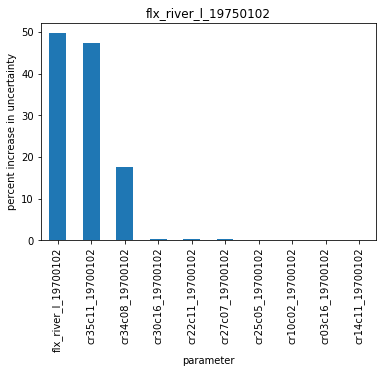

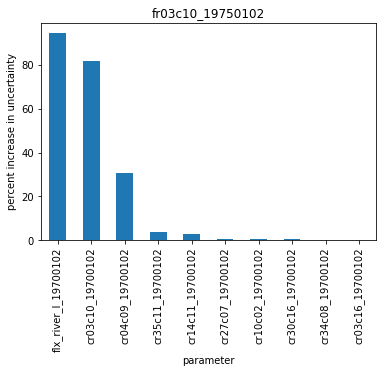

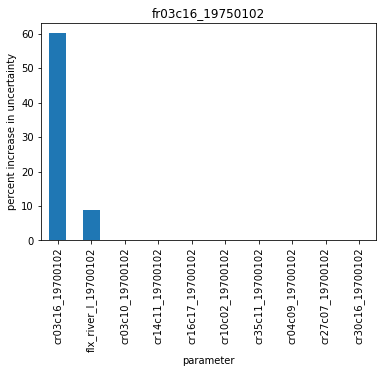

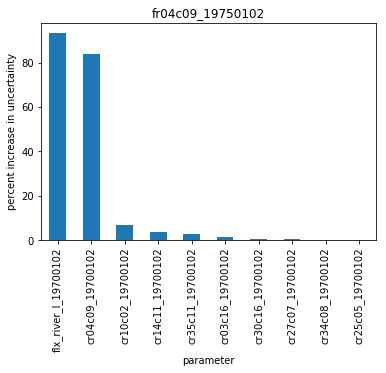

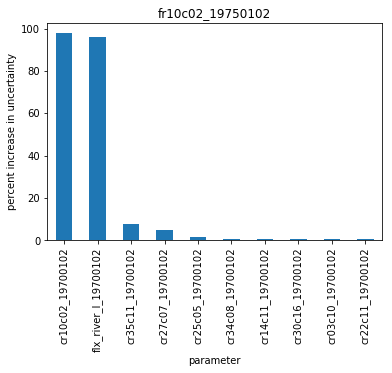

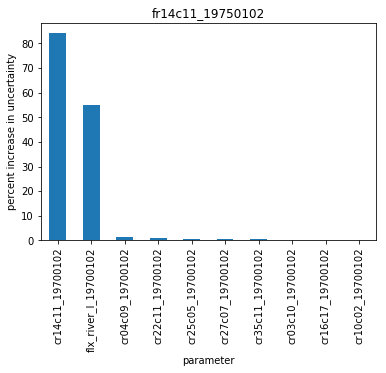

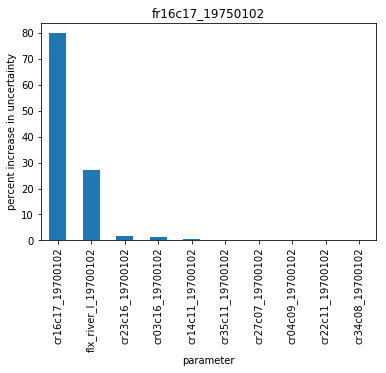

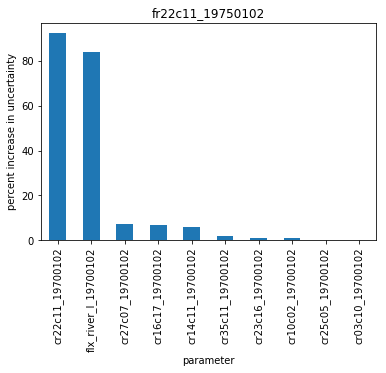

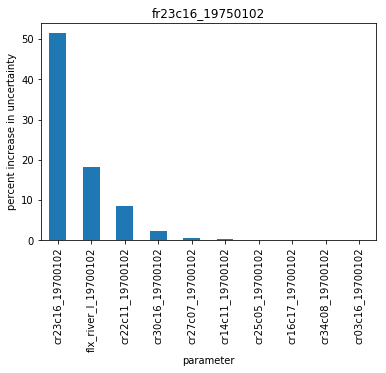

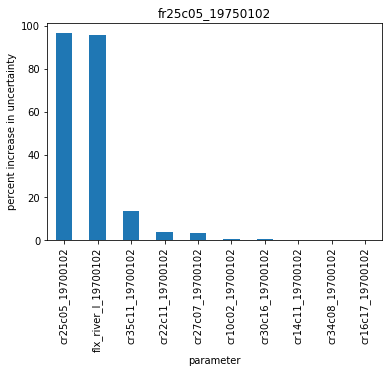

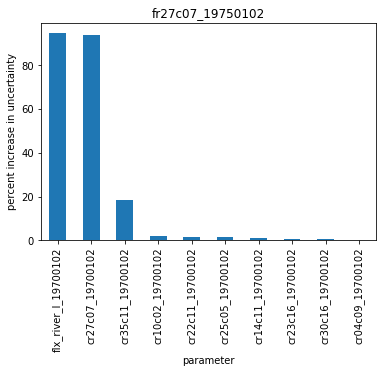

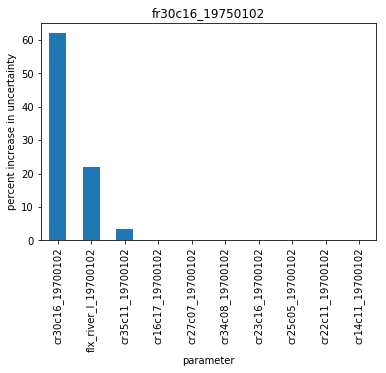

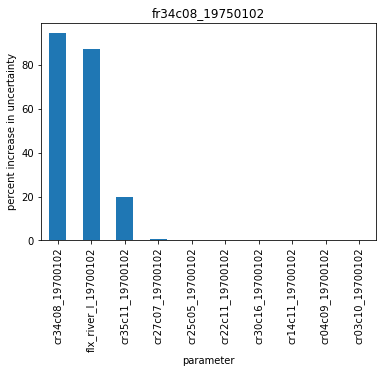

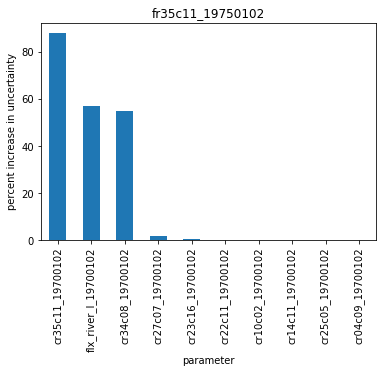

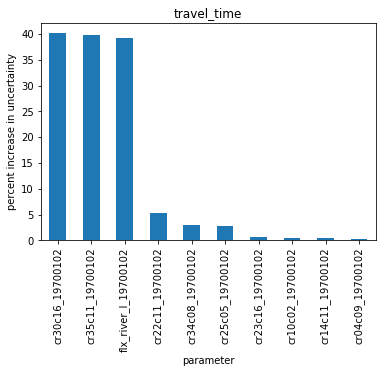

In [12]:
for forecast in df_rm.columns:
    ax = df_rm.sort_values(by=forecast,ascending=False).loc[:,forecast].iloc[:10].plot(kind="bar")
    ax.set_title(forecast)
    ax.set_ylabel("percent increase in uncertainty")
    ax.set_xlabel("parameter")
    plt.show()

### Estimating the value of yet-to-be-collected observations

### Using the assumptions of FOSM, we can also calculate the value of observations we don't have yet!  Black magic!  

### Not really, we carried these possible data locations as ``observations`` in the control file - this means each one has a row in the jacobian (just like any other output of interest).  If we then assume some value of measurement noise (a non-zero weight in the control file), we can run a hypothetical "calibration" analysis using Schur compliment.  Remember, FOSM doesn't care about actual values of parameters, observations, or forecasts, only sensitivities...

### In pyemu, the ``Schur.get_added_obs_importance()`` method calculates the *decrease* in uncertainty resulting for having new obsevations during calibration.  It accepts an optional argument ``obslist_dict`` which is a python dictionary of groups of new observations to test.  

### Here we will test the value of having the water level in each unmeasured model cell.  Then we can make maps of where to collect new data...these calculations take a little while to run because we are repeatedly calculating the entire FOSM process for each new observation location 

In [13]:
pobs_names = [o for o in sc.pst.obs_names if o.startswith("pr") and "19700102" in o]
df_ad = sc.get_added_obs_importance(obslist_dict={oname:oname for oname in pobs_names},
                                base_obslist=sc.pst.nnz_obs_names,reset_zero_weight=True)

In [14]:
df_ad.min()

flx_river_l_19750102    1.306662e+03
fr03c10_19750102        1.757031e-02
fr03c16_19750102        1.204457e-02
fr04c09_19750102        2.649054e-02
fr10c02_19750102        4.217605e-02
fr14c11_19750102        2.631775e-02
fr16c17_19750102        1.782716e-02
fr22c11_19750102        1.722950e-02
fr23c16_19750102        1.103768e-02
fr25c05_19750102        3.027936e-02
fr27c07_19750102        2.645125e-02
fr30c16_19750102        1.159345e-02
fr34c08_19750102        2.951146e-02
fr35c11_19750102        2.746185e-02
travel_time             2.398976e+07
dtype: float64

In [15]:
df_ad.max()

flx_river_l_19750102    1.413967e+03
fr03c10_19750102        1.853418e-02
fr03c16_19750102        1.424380e-02
fr04c09_19750102        2.962466e-02
fr10c02_19750102        4.823210e-02
fr14c11_19750102        3.425972e-02
fr16c17_19750102        1.930953e-02
fr22c11_19750102        1.807004e-02
fr23c16_19750102        1.346418e-02
fr25c05_19750102        3.316538e-02
fr27c07_19750102        2.749926e-02
fr30c16_19750102        1.414684e-02
fr34c08_19750102        3.107640e-02
fr35c11_19750102        3.139730e-02
travel_time             2.883926e+07
dtype: float64

In [16]:
# just a helper function to make maps of data worth
m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir)
obs = pst.observation_data
hobs = obs.loc[obs.obgnme=="calhead",:].copy()
hobs.loc[:,"i"] = hobs.obsnme.apply(lambda x: int(x[2:4])-1)
hobs.loc[:,"j"] = hobs.obsnme.apply(lambda x: int(x.split('_')[0].split('c')[-1])-1)
hobs.loc[:,"x"] = m.sr.xcentergrid[hobs.i,hobs.j]
hobs.loc[:,"y"] = m.sr.ycentergrid[hobs.i,hobs.j]
wdata = pd.DataFrame.from_records(m.wel.stress_period_data[0])
wdata.loc[:,"x"] = m.sr.xcentergrid[wdata.i,wdata.j]
wdata.loc[:,"y"] = m.sr.ycentergrid[wdata.i,wdata.j]
pp_df = pyemu.pp_utils.pp_file_to_dataframe(os.path.join(working_dir,"hkpp.dat"))
def plot_added_worth(df):
    df_base = df.loc["base",:]
    df_frac = 100.0 * (1.0 - (df / df_base))
    df_frac = df_frac.loc[pobs_names,:]
    df_frac.loc[:,"i"] = df_frac.index.map(lambda x: int(x[2:4])-1)
    df_frac.loc[:,"j"] = df_frac.index.map(lambda x: int(x[5:7])-1)
    #print(df_frac.)
    for forecast in sc.pst.forecast_names:
        print(forecast)
        arr = np.zeros((m.nrow,m.ncol)) - 1
        arr[df_frac.i,df_frac.j] = df_frac.loc[:,forecast]
        arr = np.ma.masked_where(arr < 0.0 ,arr)
        fig = plt.figure(figsize=(12,10))
        
        ax = plt.subplot(111,aspect="equal")
        c = ax.pcolormesh(m.sr.xedge,m.sr.yedge,arr,alpha=0.75)
        plt.colorbar(c)
        if forecast.startswith("fr"):
            i = int(forecast[2:4]) - 1
            j = int(forecast.split('_')[0].split('c')[-1]) - 1
            x,y = m.sr.xcentergrid[i,j],m.sr.ycentergrid[i,j]
            ax.scatter([x],[y],marker='o',color='r',s=150)
            #ax2.scatter([x],[y],marker='o',color='r',s=150)    
        ax.scatter(hobs.x,hobs.y,marker='x',s=100,color='y')
        ax.scatter(wdata.x,wdata.y,marker='*',s=100,color='m')
        ax.scatter(pp_df.x,pp_df.y,marker='.',color='w',s=50)
        ax.set_title(forecast)
        
        plt.show()
        plt.close(fig)
    

### Now we are going to plot the worth (reduction in uncertainty) of a single, new water level measurement for each forecast (forecast name is the title of each plot). So these plots show us where to go collect new data to reduce forecast uncertainty as much as possible...red circles show the forecast (for water level forecasts), yellow X's are the locations of existing water levels, purple stars mark pumping well locations (pumping rates are treated as uncertain!)

fr03c10_19750102


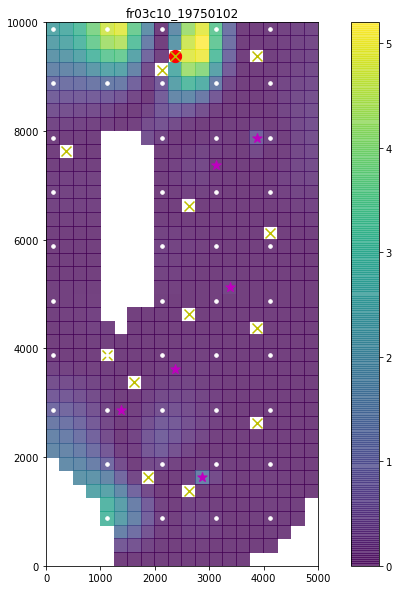

fr03c16_19750102


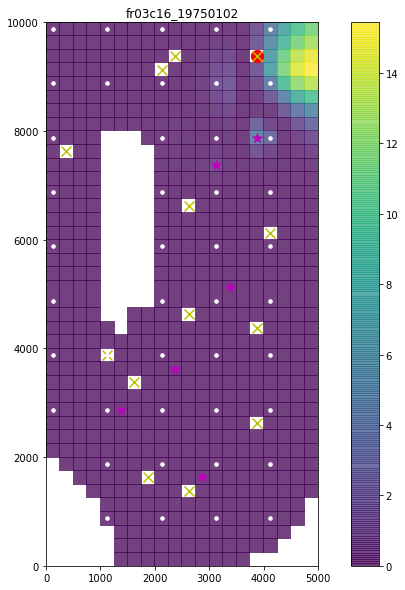

fr04c09_19750102


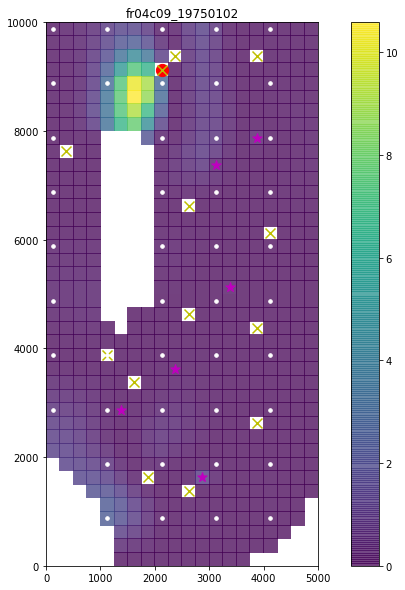

fr10c02_19750102


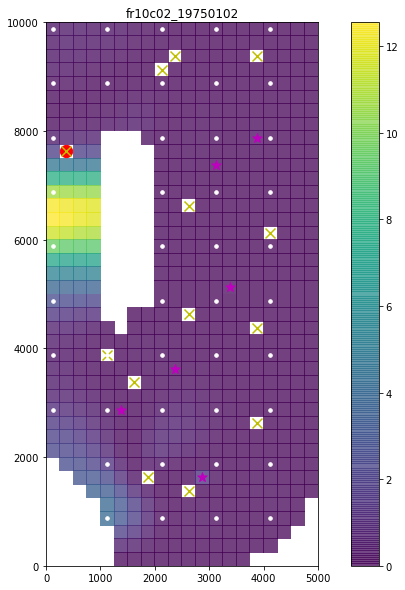

fr14c11_19750102


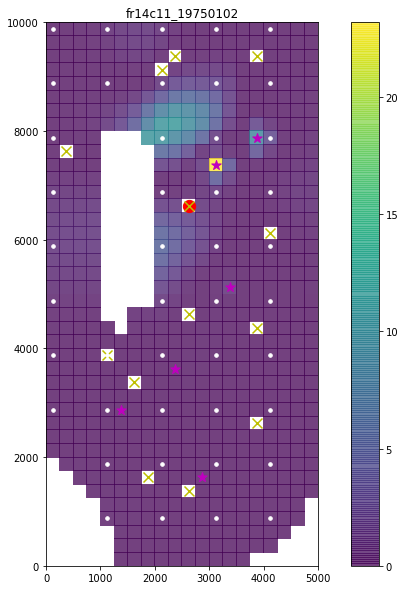

fr16c17_19750102


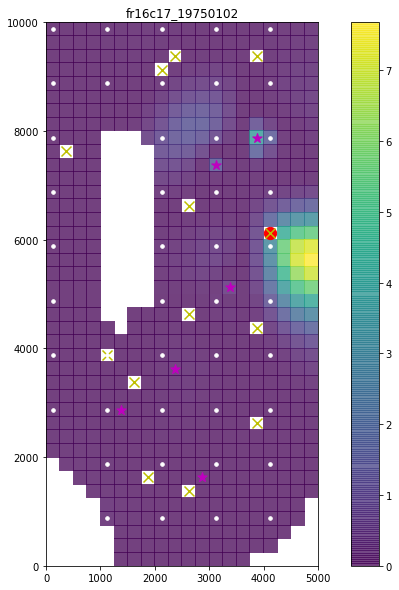

fr22c11_19750102


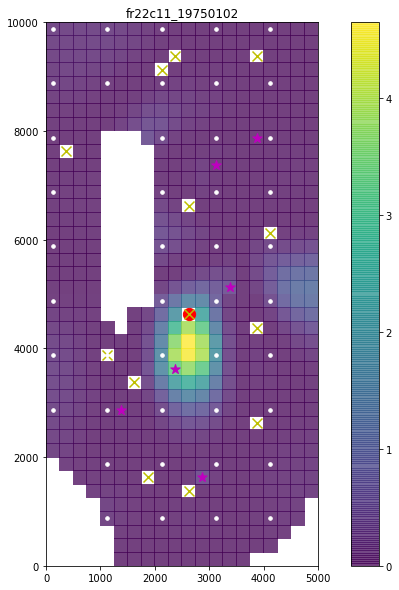

fr23c16_19750102


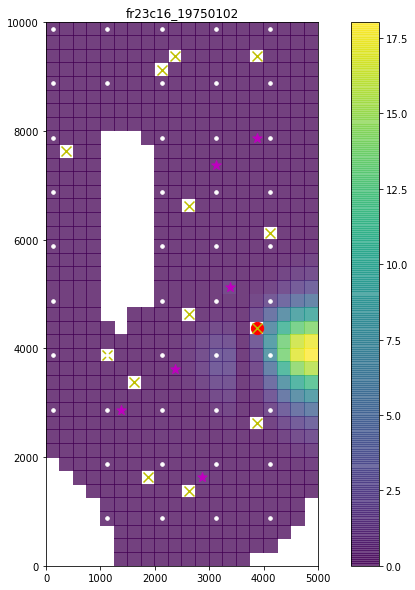

fr25c05_19750102


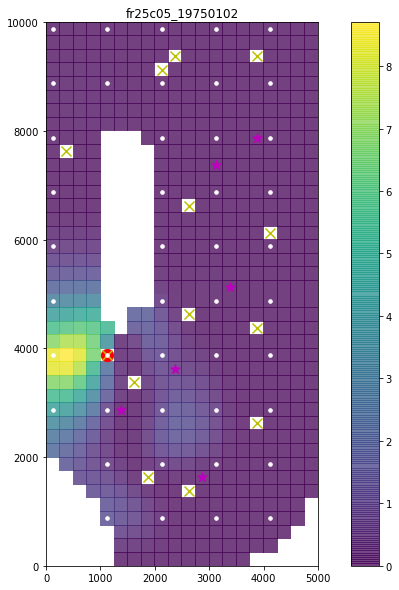

fr27c07_19750102


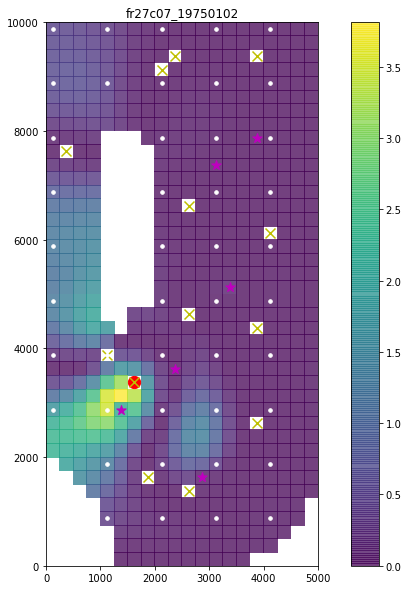

fr30c16_19750102


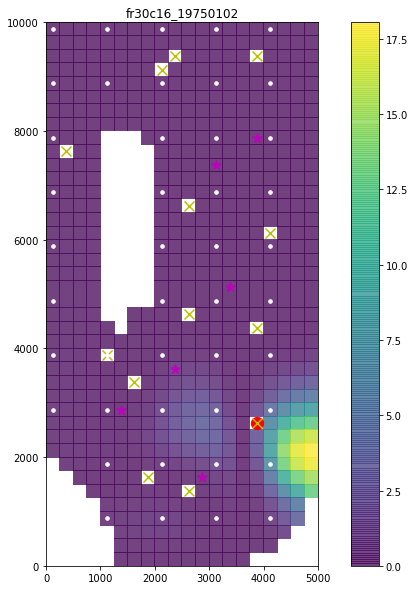

fr34c08_19750102


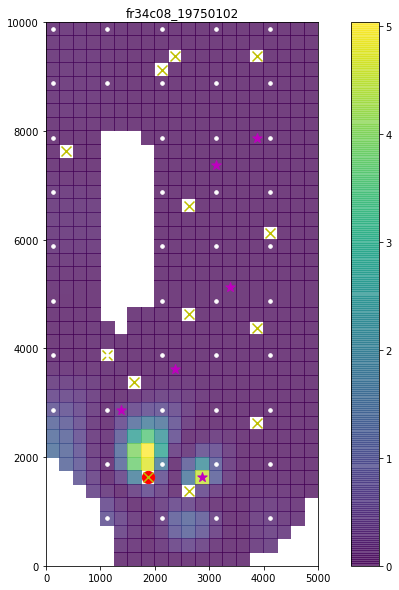

fr35c11_19750102


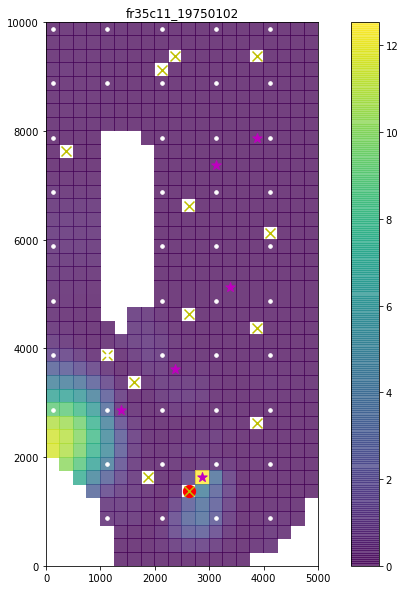

flx_river_l_19750102


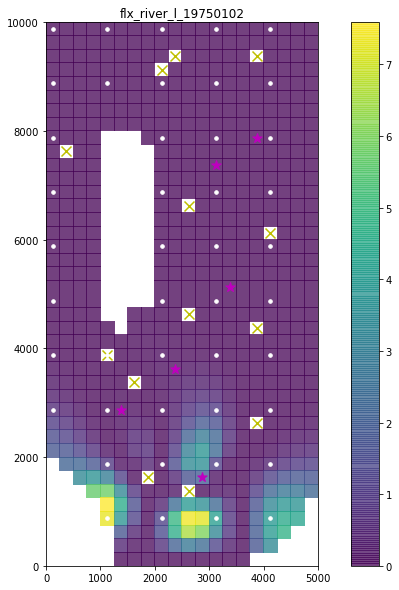

travel_time


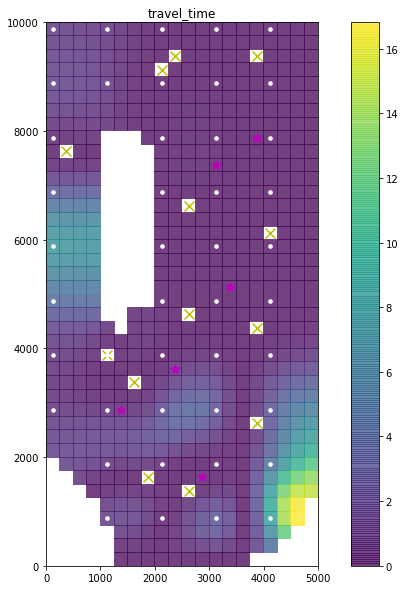

In [17]:
plot_added_worth(df_ad)

Ok, so those are cool.  And, unlike the zoned-parameterization dataworth, these make sense from a physical interpretation standpoint

Let's explore what happens when we use a full covariance prior

In [18]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500.0)
gs = pyemu.geostats.GeoStruct(variograms=[v])
cov = pyemu.helpers.pilotpoint_prior_builder(sc.pst,
                            struct_dict={gs:os.path.join(working_dir,"hkpp.dat.tpl")})

/Users/jwhite/Dev/python/pyemu/pyemu/utils/helpers.py:55: UserWarning: 'pilotpoint_prior_builder' has been renamed to 'geostatistical_prior_builder'
  "'geostatistical_prior_builder'")


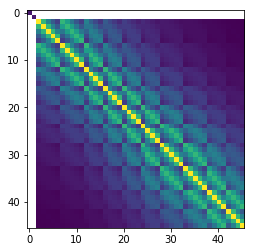

In [19]:
x = np.ma.masked_where(cov.x==0,cov.x)
plt.imshow(x)

In [20]:
sc_full = pyemu.Schur(jco=sc.jco,pst=sc.pst,parcov=cov,forecasts=sc.forecasts,verbose=True)

2017-09-10 15:11:46.863200 starting: pre-loading base components
2017-09-10 15:11:46.863700 starting: loading obscov
2017-09-10 15:11:47.062050 finished: loading obscov took: 0:00:00.198350
2017-09-10 15:11:47.062146 starting: loading forecasts
2017-09-10 15:11:47.070593 finished: loading forecasts took: 0:00:00.008447
2017-09-10 15:11:47.070810 forecast names: fr03c10_19750102,fr03c16_19750102,fr04c09_19750102,fr10c02_19750102,fr14c11_19750102,fr16c17_19750102,fr22c11_19750102,fr23c16_19750102,fr25c05_19750102,fr27c07_19750102,fr30c16_19750102,fr34c08_19750102,fr35c11_19750102,flx_river_l_19750102,travel_time
2017-09-10 15:11:47.070849 finished: pre-loading base components took: 0:00:00.207649
2017-09-10 15:11:47.070883 starting: dropping prior information
2017-09-10 15:11:47.071631 starting: removing 0 prior info from jco, pst, and obs cov
2017-09-10 15:11:47.073426 finished: removing 0 prior info from jco, pst, and obs cov took: 0:00:00.001795
2017-09-10 15:11:47.073694 finished: dr

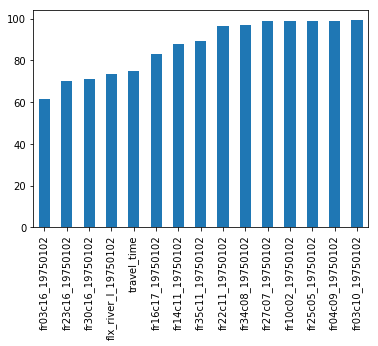

In [21]:
sc.get_forecast_summary().sort_values(by='percent_reduction').percent_reduction.plot(kind="bar")

In [22]:
df_full = sc_full.get_forecast_summary()
df_full.loc[:,"full"] = df_full.percent_reduction
df_full.loc[:,"diag"] = sc.get_forecast_summary().percent_reduction

2017-09-10 15:11:47.289007 starting: propagating prior to predictions
2017-09-10 15:11:47.292208 finished: propagating prior to predictions took: 0:00:00.003201
2017-09-10 15:11:47.292316 starting: propagating posterior to predictions
2017-09-10 15:11:47.292898 starting: Schur's complement
2017-09-10 15:11:47.293521 starting: xtqx
2017-09-10 15:11:48.573866 finished: xtqx took: 0:00:01.280345
2017-09-10 15:11:48.574501 finished: Schur's complement took: 0:00:01.281603
2017-09-10 15:11:48.574844 finished: propagating posterior to predictions took: 0:00:01.282528


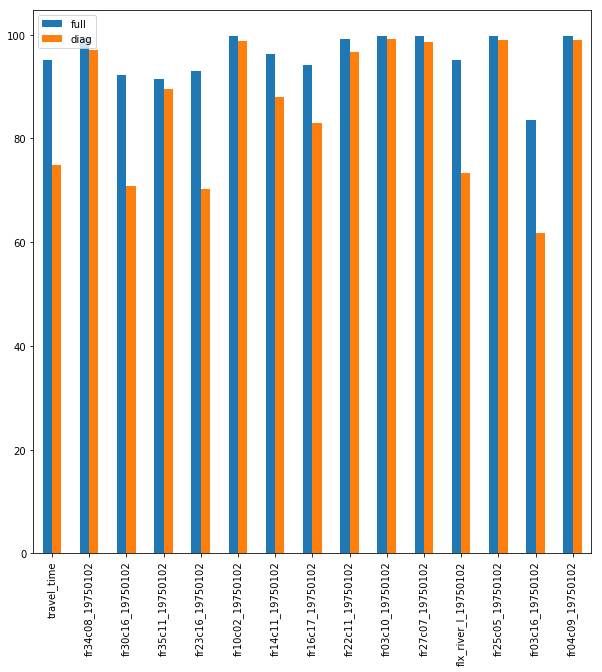

In [23]:
df_full.loc[:,["full","diag"]].plot(kind="bar",figsize=(10,10))

### Why did percent reduction increase for all forecasts increase???

In [24]:
df_full.prior_var

travel_time             4.816976e+08
fr34c08_19750102        3.982722e+00
fr30c16_19750102        1.471837e-01
fr35c11_19750102        3.028776e-01
fr23c16_19750102        1.324689e-01
fr10c02_19750102        2.607196e+01
fr14c11_19750102        6.869746e-01
fr16c17_19750102        2.760667e-01
fr22c11_19750102        1.760011e+00
fr03c10_19750102        8.541809e+00
fr27c07_19750102        1.007493e+01
flx_river_l_19750102    1.461277e+04
fr25c05_19750102        1.621692e+01
fr03c16_19750102        6.437394e-02
fr04c09_19750102        1.105415e+01
Name: prior_var, dtype: float64

In [25]:
sc.get_forecast_summary().prior_var

travel_time             1.145390e+08
fr34c08_19750102        1.057399e+00
fr30c16_19750102        4.860117e-02
fr35c11_19750102        2.981501e-01
fr23c16_19750102        4.526928e-02
fr10c02_19750102        4.285211e+00
fr14c11_19750102        2.847725e-01
fr16c17_19750102        1.137371e-01
fr22c11_19750102        5.481131e-01
fr03c10_19750102        2.274138e+00
fr27c07_19750102        2.058207e+00
flx_river_l_19750102    5.316678e+03
fr25c05_19750102        3.043277e+00
fr03c16_19750102        3.721657e-02
fr04c09_19750102        2.745582e+00
Name: prior_var, dtype: float64

### Let's recalculate the value of possible new observations...this takes longer now that we are using a full covaraince matrix because the repeated matrix-matrix products...

In [27]:
df_full = sc_full.get_added_obs_importance(obslist_dict={oname:oname for oname in pobs_names},
                                base_obslist=sc.pst.nnz_obs_names,reset_zero_weight=True)

2017-09-10 15:11:51.104860 resetting zero weights to 1.0
2017-09-10 15:11:51.459735 starting: resetting zero weight obs in base_obslist
2017-09-10 15:11:51.471247 finished: resetting zero weight obs in base_obslist took: 0:00:00.011512
2017-09-10 15:11:51.471324 starting: resetting zero weight obs in pr27c06_19700102
2017-09-10 15:11:51.482875 finished: resetting zero weight obs in pr27c06_19700102 took: 0:00:00.011551
2017-09-10 15:11:51.482973 starting: resetting zero weight obs in pr09c16_19700102
2017-09-10 15:11:51.494122 finished: resetting zero weight obs in pr09c16_19700102 took: 0:00:00.011149
2017-09-10 15:11:51.494222 starting: resetting zero weight obs in pr03c05_19700102
2017-09-10 15:11:51.505092 finished: resetting zero weight obs in pr03c05_19700102 took: 0:00:00.010870
2017-09-10 15:11:51.505173 starting: resetting zero weight obs in pr22c19_19700102
2017-09-10 15:11:51.516397 finished: resetting zero weight obs in pr22c19_19700102 took: 0:00:00.011224
2017-09-10 15:11

2017-09-10 15:11:52.121291 starting: resetting zero weight obs in pr27c18_19700102
2017-09-10 15:11:52.134261 finished: resetting zero weight obs in pr27c18_19700102 took: 0:00:00.012970
2017-09-10 15:11:52.134520 starting: resetting zero weight obs in pr25c13_19700102
2017-09-10 15:11:52.148870 finished: resetting zero weight obs in pr25c13_19700102 took: 0:00:00.014350
2017-09-10 15:11:52.148957 starting: resetting zero weight obs in pr06c17_19700102
2017-09-10 15:11:52.162715 finished: resetting zero weight obs in pr06c17_19700102 took: 0:00:00.013758
2017-09-10 15:11:52.162846 starting: resetting zero weight obs in pr37c15_19700102
2017-09-10 15:11:52.176454 finished: resetting zero weight obs in pr37c15_19700102 took: 0:00:00.013608
2017-09-10 15:11:52.176525 starting: resetting zero weight obs in pr26c13_19700102
2017-09-10 15:11:52.188647 finished: resetting zero weight obs in pr26c13_19700102 took: 0:00:00.012122
2017-09-10 15:11:52.188709 starting: resetting zero weight obs in

2017-09-10 15:11:52.787310 starting: resetting zero weight obs in pr07c15_19700102
2017-09-10 15:11:52.801469 finished: resetting zero weight obs in pr07c15_19700102 took: 0:00:00.014159
2017-09-10 15:11:52.801561 starting: resetting zero weight obs in pr33c04_19700102
2017-09-10 15:11:52.816587 finished: resetting zero weight obs in pr33c04_19700102 took: 0:00:00.015026
2017-09-10 15:11:52.816687 starting: resetting zero weight obs in pr38c15_19700102
2017-09-10 15:11:52.830944 finished: resetting zero weight obs in pr38c15_19700102 took: 0:00:00.014257
2017-09-10 15:11:52.831047 starting: resetting zero weight obs in pr09c19_19700102
2017-09-10 15:11:52.845940 finished: resetting zero weight obs in pr09c19_19700102 took: 0:00:00.014893
2017-09-10 15:11:52.846005 starting: resetting zero weight obs in pr13c13_19700102
2017-09-10 15:11:52.860717 finished: resetting zero weight obs in pr13c13_19700102 took: 0:00:00.014712
2017-09-10 15:11:52.860835 starting: resetting zero weight obs in

2017-09-10 15:11:53.427920 starting: resetting zero weight obs in pr40c11_19700102
2017-09-10 15:11:53.443514 finished: resetting zero weight obs in pr40c11_19700102 took: 0:00:00.015594
2017-09-10 15:11:53.443650 starting: resetting zero weight obs in pr37c19_19700102
2017-09-10 15:11:53.459927 finished: resetting zero weight obs in pr37c19_19700102 took: 0:00:00.016277
2017-09-10 15:11:53.460080 starting: resetting zero weight obs in pr19c20_19700102
2017-09-10 15:11:53.478617 finished: resetting zero weight obs in pr19c20_19700102 took: 0:00:00.018537
2017-09-10 15:11:53.478683 starting: resetting zero weight obs in pr22c07_19700102
2017-09-10 15:11:53.492997 finished: resetting zero weight obs in pr22c07_19700102 took: 0:00:00.014314
2017-09-10 15:11:53.493069 starting: resetting zero weight obs in pr39c08_19700102
2017-09-10 15:11:53.508173 finished: resetting zero weight obs in pr39c08_19700102 took: 0:00:00.015104
2017-09-10 15:11:53.508238 starting: resetting zero weight obs in

2017-09-10 15:11:54.295627 starting: resetting zero weight obs in pr35c04_19700102
2017-09-10 15:11:54.314277 finished: resetting zero weight obs in pr35c04_19700102 took: 0:00:00.018650
2017-09-10 15:11:54.314388 starting: resetting zero weight obs in pr16c12_19700102
2017-09-10 15:11:54.330886 finished: resetting zero weight obs in pr16c12_19700102 took: 0:00:00.016498
2017-09-10 15:11:54.330973 starting: resetting zero weight obs in pr31c17_19700102
2017-09-10 15:11:54.346617 finished: resetting zero weight obs in pr31c17_19700102 took: 0:00:00.015644
2017-09-10 15:11:54.346682 starting: resetting zero weight obs in pr25c19_19700102
2017-09-10 15:11:54.361571 finished: resetting zero weight obs in pr25c19_19700102 took: 0:00:00.014889
2017-09-10 15:11:54.361641 starting: resetting zero weight obs in pr21c20_19700102
2017-09-10 15:11:54.376752 finished: resetting zero weight obs in pr21c20_19700102 took: 0:00:00.015111
2017-09-10 15:11:54.376821 starting: resetting zero weight obs in

2017-09-10 15:11:55.180289 finished: resetting zero weight obs in pr29c17_19700102 took: 0:00:00.017983
2017-09-10 15:11:55.180397 starting: resetting zero weight obs in pr08c12_19700102
2017-09-10 15:11:55.201261 finished: resetting zero weight obs in pr08c12_19700102 took: 0:00:00.020864
2017-09-10 15:11:55.201367 starting: resetting zero weight obs in pr07c01_19700102
2017-09-10 15:11:55.218968 finished: resetting zero weight obs in pr07c01_19700102 took: 0:00:00.017601
2017-09-10 15:11:55.219071 starting: resetting zero weight obs in pr09c20_19700102
2017-09-10 15:11:55.236381 finished: resetting zero weight obs in pr09c20_19700102 took: 0:00:00.017310
2017-09-10 15:11:55.236484 starting: resetting zero weight obs in pr28c02_19700102
2017-09-10 15:11:55.253494 finished: resetting zero weight obs in pr28c02_19700102 took: 0:00:00.017010
2017-09-10 15:11:55.253587 starting: resetting zero weight obs in pr32c16_19700102
2017-09-10 15:11:55.271726 finished: resetting zero weight obs in

2017-09-10 15:11:56.035476 starting: resetting zero weight obs in pr07c07_19700102
2017-09-10 15:11:56.052897 finished: resetting zero weight obs in pr07c07_19700102 took: 0:00:00.017421
2017-09-10 15:11:56.053009 starting: resetting zero weight obs in pr14c03_19700102
2017-09-10 15:11:56.070764 finished: resetting zero weight obs in pr14c03_19700102 took: 0:00:00.017755
2017-09-10 15:11:56.070857 starting: resetting zero weight obs in pr36c14_19700102
2017-09-10 15:11:56.087822 finished: resetting zero weight obs in pr36c14_19700102 took: 0:00:00.016965
2017-09-10 15:11:56.087913 starting: resetting zero weight obs in pr36c07_19700102
2017-09-10 15:11:56.104384 finished: resetting zero weight obs in pr36c07_19700102 took: 0:00:00.016471
2017-09-10 15:11:56.104463 starting: resetting zero weight obs in pr14c13_19700102
2017-09-10 15:11:56.120686 finished: resetting zero weight obs in pr14c13_19700102 took: 0:00:00.016223
2017-09-10 15:11:56.120767 starting: resetting zero weight obs in

2017-09-10 15:11:56.920732 starting: resetting zero weight obs in pr20c14_19700102
2017-09-10 15:11:56.938098 finished: resetting zero weight obs in pr20c14_19700102 took: 0:00:00.017366
2017-09-10 15:11:56.938543 starting: resetting zero weight obs in pr23c20_19700102
2017-09-10 15:11:56.955672 finished: resetting zero weight obs in pr23c20_19700102 took: 0:00:00.017129
2017-09-10 15:11:56.955763 starting: resetting zero weight obs in pr38c16_19700102
2017-09-10 15:11:56.973230 finished: resetting zero weight obs in pr38c16_19700102 took: 0:00:00.017467
2017-09-10 15:11:56.973316 starting: resetting zero weight obs in pr23c05_19700102
2017-09-10 15:11:56.990357 finished: resetting zero weight obs in pr23c05_19700102 took: 0:00:00.017041
2017-09-10 15:11:56.990438 starting: resetting zero weight obs in pr19c15_19700102
2017-09-10 15:11:57.008949 finished: resetting zero weight obs in pr19c15_19700102 took: 0:00:00.018511
2017-09-10 15:11:57.009019 starting: resetting zero weight obs in

2017-09-10 15:11:57.826627 finished: resetting zero weight obs in pr07c19_19700102 took: 0:00:00.018302
2017-09-10 15:11:57.826732 starting: resetting zero weight obs in pr07c10_19700102
2017-09-10 15:11:57.844721 finished: resetting zero weight obs in pr07c10_19700102 took: 0:00:00.017989
2017-09-10 15:11:57.844920 starting: resetting zero weight obs in pr02c04_19700102
2017-09-10 15:11:57.863130 finished: resetting zero weight obs in pr02c04_19700102 took: 0:00:00.018210
2017-09-10 15:11:57.863240 starting: resetting zero weight obs in pr06c04_19700102
2017-09-10 15:11:57.882683 finished: resetting zero weight obs in pr06c04_19700102 took: 0:00:00.019443
2017-09-10 15:11:57.882778 starting: resetting zero weight obs in pr03c07_19700102
2017-09-10 15:11:57.900872 finished: resetting zero weight obs in pr03c07_19700102 took: 0:00:00.018094
2017-09-10 15:11:57.900957 starting: resetting zero weight obs in pr37c06_19700102
2017-09-10 15:11:57.918461 finished: resetting zero weight obs in

2017-09-10 15:11:58.668887 starting: resetting zero weight obs in pr22c03_19700102
2017-09-10 15:11:58.687454 finished: resetting zero weight obs in pr22c03_19700102 took: 0:00:00.018567
2017-09-10 15:11:58.687557 starting: resetting zero weight obs in pr30c01_19700102
2017-09-10 15:11:58.706922 finished: resetting zero weight obs in pr30c01_19700102 took: 0:00:00.019365
2017-09-10 15:11:58.707006 starting: resetting zero weight obs in pr22c16_19700102
2017-09-10 15:11:58.723850 finished: resetting zero weight obs in pr22c16_19700102 took: 0:00:00.016844
2017-09-10 15:11:58.723921 starting: resetting zero weight obs in pr04c02_19700102
2017-09-10 15:11:58.740505 finished: resetting zero weight obs in pr04c02_19700102 took: 0:00:00.016584
2017-09-10 15:11:58.740589 starting: resetting zero weight obs in pr01c07_19700102
2017-09-10 15:11:58.756865 finished: resetting zero weight obs in pr01c07_19700102 took: 0:00:00.016276
2017-09-10 15:11:58.756936 starting: resetting zero weight obs in

2017-09-10 15:11:59.570922 finished: resetting zero weight obs in pr05c14_19700102 took: 0:00:00.017888
2017-09-10 15:11:59.571111 starting: resetting zero weight obs in pr34c13_19700102
2017-09-10 15:11:59.591071 finished: resetting zero weight obs in pr34c13_19700102 took: 0:00:00.019960
2017-09-10 15:11:59.591171 starting: resetting zero weight obs in pr13c18_19700102
2017-09-10 15:11:59.610225 finished: resetting zero weight obs in pr13c18_19700102 took: 0:00:00.019054
2017-09-10 15:11:59.610308 starting: resetting zero weight obs in pr04c12_19700102
2017-09-10 15:11:59.631828 finished: resetting zero weight obs in pr04c12_19700102 took: 0:00:00.021520
2017-09-10 15:11:59.631907 starting: resetting zero weight obs in pr22c17_19700102
2017-09-10 15:11:59.654536 finished: resetting zero weight obs in pr22c17_19700102 took: 0:00:00.022629
2017-09-10 15:11:59.654673 starting: resetting zero weight obs in pr32c17_19700102
2017-09-10 15:11:59.673268 finished: resetting zero weight obs in

2017-09-10 15:12:00.461783 finished: resetting zero weight obs in pr03c14_19700102 took: 0:00:00.019664
2017-09-10 15:12:00.461918 starting: resetting zero weight obs in pr37c13_19700102
2017-09-10 15:12:00.482702 finished: resetting zero weight obs in pr37c13_19700102 took: 0:00:00.020784
2017-09-10 15:12:00.482802 starting: resetting zero weight obs in pr06c19_19700102
2017-09-10 15:12:00.504523 finished: resetting zero weight obs in pr06c19_19700102 took: 0:00:00.021721
2017-09-10 15:12:00.504627 starting: resetting zero weight obs in pr17c13_19700102
2017-09-10 15:12:00.523722 finished: resetting zero weight obs in pr17c13_19700102 took: 0:00:00.019095
2017-09-10 15:12:00.523807 starting: resetting zero weight obs in pr13c10_19700102
2017-09-10 15:12:00.543186 finished: resetting zero weight obs in pr13c10_19700102 took: 0:00:00.019379
2017-09-10 15:12:00.543281 starting: resetting zero weight obs in pr25c16_19700102
2017-09-10 15:12:00.562105 finished: resetting zero weight obs in

2017-09-10 15:12:01.336919 finished: resetting zero weight obs in pr21c17_19700102 took: 0:00:00.019450
2017-09-10 15:12:01.337072 starting: resetting zero weight obs in pr40c15_19700102
2017-09-10 15:12:01.356907 finished: resetting zero weight obs in pr40c15_19700102 took: 0:00:00.019835
2017-09-10 15:12:01.357008 starting: resetting zero weight obs in pr37c08_19700102
2017-09-10 15:12:01.376193 finished: resetting zero weight obs in pr37c08_19700102 took: 0:00:00.019185
2017-09-10 15:12:01.376290 starting: resetting zero weight obs in pr25c08_19700102
2017-09-10 15:12:01.395447 finished: resetting zero weight obs in pr25c08_19700102 took: 0:00:00.019157
2017-09-10 15:12:01.395532 starting: resetting zero weight obs in pr05c19_19700102
2017-09-10 15:12:01.417413 finished: resetting zero weight obs in pr05c19_19700102 took: 0:00:00.021881
2017-09-10 15:12:01.417509 starting: resetting zero weight obs in pr24c01_19700102
2017-09-10 15:12:01.437256 finished: resetting zero weight obs in

2017-09-10 15:12:02.395762 finished: resetting zero weight obs in pr04c01_19700102 took: 0:00:00.017469
2017-09-10 15:12:02.396177 starting: resetting zero weight obs in pr12c03_19700102
2017-09-10 15:12:02.415057 finished: resetting zero weight obs in pr12c03_19700102 took: 0:00:00.018880
2017-09-10 15:12:02.415163 starting: resetting zero weight obs in pr11c20_19700102
2017-09-10 15:12:02.434021 finished: resetting zero weight obs in pr11c20_19700102 took: 0:00:00.018858
2017-09-10 15:12:02.434139 starting: resetting zero weight obs in pr34c18_19700102
2017-09-10 15:12:02.452192 finished: resetting zero weight obs in pr34c18_19700102 took: 0:00:00.018053
2017-09-10 15:12:02.452268 starting: resetting zero weight obs in pr01c16_19700102
2017-09-10 15:12:02.469397 finished: resetting zero weight obs in pr01c16_19700102 took: 0:00:00.017129
2017-09-10 15:12:02.469468 starting: resetting zero weight obs in pr07c04_19700102
2017-09-10 15:12:02.486325 finished: resetting zero weight obs in

2017-09-10 15:12:03.270988 finished: resetting zero weight obs in pr38c06_19700102 took: 0:00:00.018493
2017-09-10 15:12:03.271096 starting: resetting zero weight obs in pr37c07_19700102
2017-09-10 15:12:03.291047 finished: resetting zero weight obs in pr37c07_19700102 took: 0:00:00.019951
2017-09-10 15:12:03.291161 starting: resetting zero weight obs in pr35c20_19700102
2017-09-10 15:12:03.311011 finished: resetting zero weight obs in pr35c20_19700102 took: 0:00:00.019850
2017-09-10 15:12:03.311128 starting: resetting zero weight obs in pr26c14_19700102
2017-09-10 15:12:03.330982 finished: resetting zero weight obs in pr26c14_19700102 took: 0:00:00.019854
2017-09-10 15:12:03.331099 starting: resetting zero weight obs in pr30c12_19700102
2017-09-10 15:12:03.353487 finished: resetting zero weight obs in pr30c12_19700102 took: 0:00:00.022388
2017-09-10 15:12:03.353601 starting: resetting zero weight obs in pr03c03_19700102
2017-09-10 15:12:03.372100 finished: resetting zero weight obs in

2017-09-10 15:12:04.157951 finished: calculating importance of observations by adding: ['pr26c11_19700102']
 took: 0:00:00.014132
2017-09-10 15:12:04.158136 starting: calculating importance of observations by adding: ['pr33c09_19700102']

2017-09-10 15:12:04.172273 finished: calculating importance of observations by adding: ['pr33c09_19700102']
 took: 0:00:00.014137
2017-09-10 15:12:04.172361 starting: calculating importance of observations by adding: ['pr17c17_19700102']

2017-09-10 15:12:04.186281 finished: calculating importance of observations by adding: ['pr17c17_19700102']
 took: 0:00:00.013920
2017-09-10 15:12:04.186364 starting: calculating importance of observations by adding: ['pr03c15_19700102']

2017-09-10 15:12:04.199551 finished: calculating importance of observations by adding: ['pr03c15_19700102']
 took: 0:00:00.013187
2017-09-10 15:12:04.199630 starting: calculating importance of observations by adding: ['pr26c12_19700102']

2017-09-10 15:12:04.212361 finished: calcula

2017-09-10 15:12:04.765082 starting: calculating importance of observations by adding: ['pr39c09_19700102']

2017-09-10 15:12:04.780386 finished: calculating importance of observations by adding: ['pr39c09_19700102']
 took: 0:00:00.015304
2017-09-10 15:12:04.780455 starting: calculating importance of observations by adding: ['pr05c03_19700102']

2017-09-10 15:12:04.795147 finished: calculating importance of observations by adding: ['pr05c03_19700102']
 took: 0:00:00.014692
2017-09-10 15:12:04.795236 starting: calculating importance of observations by adding: ['pr04c10_19700102']

2017-09-10 15:12:04.809190 finished: calculating importance of observations by adding: ['pr04c10_19700102']
 took: 0:00:00.013954
2017-09-10 15:12:04.809263 starting: calculating importance of observations by adding: ['pr22c18_19700102']

2017-09-10 15:12:04.822489 finished: calculating importance of observations by adding: ['pr22c18_19700102']
 took: 0:00:00.013226
2017-09-10 15:12:04.822559 starting: calcula

2017-09-10 15:12:05.409590 finished: calculating importance of observations by adding: ['pr23c14_19700102']
 took: 0:00:00.013801
2017-09-10 15:12:05.409653 starting: calculating importance of observations by adding: ['pr29c03_19700102']

2017-09-10 15:12:05.424452 finished: calculating importance of observations by adding: ['pr29c03_19700102']
 took: 0:00:00.014799
2017-09-10 15:12:05.424538 starting: calculating importance of observations by adding: ['pr10c01_19700102']

2017-09-10 15:12:05.438244 finished: calculating importance of observations by adding: ['pr10c01_19700102']
 took: 0:00:00.013706
2017-09-10 15:12:05.438318 starting: calculating importance of observations by adding: ['pr12c17_19700102']

2017-09-10 15:12:05.450822 finished: calculating importance of observations by adding: ['pr12c17_19700102']
 took: 0:00:00.012504
2017-09-10 15:12:05.450892 starting: calculating importance of observations by adding: ['pr23c01_19700102']

2017-09-10 15:12:05.464184 finished: calcula

2017-09-10 15:12:06.029314 starting: calculating importance of observations by adding: ['pr40c08_19700102']

2017-09-10 15:12:06.043809 finished: calculating importance of observations by adding: ['pr40c08_19700102']
 took: 0:00:00.014495
2017-09-10 15:12:06.043945 starting: calculating importance of observations by adding: ['pr28c07_19700102']

2017-09-10 15:12:06.058324 finished: calculating importance of observations by adding: ['pr28c07_19700102']
 took: 0:00:00.014379
2017-09-10 15:12:06.058404 starting: calculating importance of observations by adding: ['pr10c11_19700102']

2017-09-10 15:12:06.072314 finished: calculating importance of observations by adding: ['pr10c11_19700102']
 took: 0:00:00.013910
2017-09-10 15:12:06.072461 starting: calculating importance of observations by adding: ['pr31c20_19700102']

2017-09-10 15:12:06.085654 finished: calculating importance of observations by adding: ['pr31c20_19700102']
 took: 0:00:00.013193
2017-09-10 15:12:06.085729 starting: calcula

2017-09-10 15:12:06.682027 starting: calculating importance of observations by adding: ['pr36c16_19700102']

2017-09-10 15:12:06.697587 finished: calculating importance of observations by adding: ['pr36c16_19700102']
 took: 0:00:00.015560
2017-09-10 15:12:06.697870 starting: calculating importance of observations by adding: ['pr26c18_19700102']

2017-09-10 15:12:06.712500 finished: calculating importance of observations by adding: ['pr26c18_19700102']
 took: 0:00:00.014630
2017-09-10 15:12:06.712646 starting: calculating importance of observations by adding: ['pr24c17_19700102']

2017-09-10 15:12:06.726897 finished: calculating importance of observations by adding: ['pr24c17_19700102']
 took: 0:00:00.014251
2017-09-10 15:12:06.726987 starting: calculating importance of observations by adding: ['pr27c20_19700102']

2017-09-10 15:12:06.740759 finished: calculating importance of observations by adding: ['pr27c20_19700102']
 took: 0:00:00.013772
2017-09-10 15:12:06.740844 starting: calcula

2017-09-10 15:12:07.313847 starting: calculating importance of observations by adding: ['pr16c20_19700102']

2017-09-10 15:12:07.329150 finished: calculating importance of observations by adding: ['pr16c20_19700102']
 took: 0:00:00.015303
2017-09-10 15:12:07.329249 starting: calculating importance of observations by adding: ['pr12c14_19700102']

2017-09-10 15:12:07.343189 finished: calculating importance of observations by adding: ['pr12c14_19700102']
 took: 0:00:00.013940
2017-09-10 15:12:07.343278 starting: calculating importance of observations by adding: ['pr12c18_19700102']

2017-09-10 15:12:07.357353 finished: calculating importance of observations by adding: ['pr12c18_19700102']
 took: 0:00:00.014075
2017-09-10 15:12:07.357433 starting: calculating importance of observations by adding: ['pr12c04_19700102']

2017-09-10 15:12:07.371561 finished: calculating importance of observations by adding: ['pr12c04_19700102']
 took: 0:00:00.014128
2017-09-10 15:12:07.371640 starting: calcula

2017-09-10 15:12:07.955355 finished: calculating importance of observations by adding: ['pr40c09_19700102']
 took: 0:00:00.014498
2017-09-10 15:12:07.955494 starting: calculating importance of observations by adding: ['pr28c09_19700102']

2017-09-10 15:12:07.970693 finished: calculating importance of observations by adding: ['pr28c09_19700102']
 took: 0:00:00.015199
2017-09-10 15:12:07.970767 starting: calculating importance of observations by adding: ['pr18c19_19700102']

2017-09-10 15:12:07.985062 finished: calculating importance of observations by adding: ['pr18c19_19700102']
 took: 0:00:00.014295
2017-09-10 15:12:07.985148 starting: calculating importance of observations by adding: ['pr39c07_19700102']

2017-09-10 15:12:07.999118 finished: calculating importance of observations by adding: ['pr39c07_19700102']
 took: 0:00:00.013970
2017-09-10 15:12:07.999202 starting: calculating importance of observations by adding: ['pr26c08_19700102']

2017-09-10 15:12:08.012725 finished: calcula

2017-09-10 15:12:08.588174 finished: calculating importance of observations by adding: ['pr02c17_19700102']
 took: 0:00:00.015020
2017-09-10 15:12:08.588641 starting: calculating importance of observations by adding: ['pr13c12_19700102']

2017-09-10 15:12:08.603579 finished: calculating importance of observations by adding: ['pr13c12_19700102']
 took: 0:00:00.014938
2017-09-10 15:12:08.603660 starting: calculating importance of observations by adding: ['pr32c20_19700102']

2017-09-10 15:12:08.618205 finished: calculating importance of observations by adding: ['pr32c20_19700102']
 took: 0:00:00.014545
2017-09-10 15:12:08.618302 starting: calculating importance of observations by adding: ['pr04c05_19700102']

2017-09-10 15:12:08.632668 finished: calculating importance of observations by adding: ['pr04c05_19700102']
 took: 0:00:00.014366
2017-09-10 15:12:08.632757 starting: calculating importance of observations by adding: ['pr06c14_19700102']

2017-09-10 15:12:08.646745 finished: calcula

2017-09-10 15:12:09.231471 finished: calculating importance of observations by adding: ['pr07c10_19700102']
 took: 0:00:00.013216
2017-09-10 15:12:09.231629 starting: calculating importance of observations by adding: ['pr02c04_19700102']

2017-09-10 15:12:09.246018 finished: calculating importance of observations by adding: ['pr02c04_19700102']
 took: 0:00:00.014389
2017-09-10 15:12:09.246100 starting: calculating importance of observations by adding: ['pr06c04_19700102']

2017-09-10 15:12:09.259259 finished: calculating importance of observations by adding: ['pr06c04_19700102']
 took: 0:00:00.013159
2017-09-10 15:12:09.259327 starting: calculating importance of observations by adding: ['pr03c07_19700102']

2017-09-10 15:12:09.271762 finished: calculating importance of observations by adding: ['pr03c07_19700102']
 took: 0:00:00.012435
2017-09-10 15:12:09.271819 starting: calculating importance of observations by adding: ['pr37c06_19700102']

2017-09-10 15:12:09.284894 finished: calcula

2017-09-10 15:12:09.858413 finished: calculating importance of observations by adding: ['pr21c18_19700102']
 took: 0:00:00.014224
2017-09-10 15:12:09.858469 starting: calculating importance of observations by adding: ['pr22c03_19700102']

2017-09-10 15:12:09.872851 finished: calculating importance of observations by adding: ['pr22c03_19700102']
 took: 0:00:00.014382
2017-09-10 15:12:09.872929 starting: calculating importance of observations by adding: ['pr30c01_19700102']

2017-09-10 15:12:09.887130 finished: calculating importance of observations by adding: ['pr30c01_19700102']
 took: 0:00:00.014201
2017-09-10 15:12:09.887200 starting: calculating importance of observations by adding: ['pr22c16_19700102']

2017-09-10 15:12:09.899679 finished: calculating importance of observations by adding: ['pr22c16_19700102']
 took: 0:00:00.012479
2017-09-10 15:12:09.899746 starting: calculating importance of observations by adding: ['pr04c02_19700102']

2017-09-10 15:12:09.913032 finished: calcula

2017-09-10 15:12:10.481260 starting: calculating importance of observations by adding: ['pr30c11_19700102']

2017-09-10 15:12:10.495588 finished: calculating importance of observations by adding: ['pr30c11_19700102']
 took: 0:00:00.014328
2017-09-10 15:12:10.495673 starting: calculating importance of observations by adding: ['pr01c19_19700102']

2017-09-10 15:12:10.510605 finished: calculating importance of observations by adding: ['pr01c19_19700102']
 took: 0:00:00.014932
2017-09-10 15:12:10.510702 starting: calculating importance of observations by adding: ['pr05c14_19700102']

2017-09-10 15:12:10.526527 finished: calculating importance of observations by adding: ['pr05c14_19700102']
 took: 0:00:00.015825
2017-09-10 15:12:10.526619 starting: calculating importance of observations by adding: ['pr34c13_19700102']

2017-09-10 15:12:10.540788 finished: calculating importance of observations by adding: ['pr34c13_19700102']
 took: 0:00:00.014169
2017-09-10 15:12:10.540869 starting: calcula

2017-09-10 15:12:11.113761 starting: calculating importance of observations by adding: ['pr19c01_19700102']

2017-09-10 15:12:11.127584 finished: calculating importance of observations by adding: ['pr19c01_19700102']
 took: 0:00:00.013823
2017-09-10 15:12:11.127649 starting: calculating importance of observations by adding: ['pr03c14_19700102']

2017-09-10 15:12:11.141556 finished: calculating importance of observations by adding: ['pr03c14_19700102']
 took: 0:00:00.013907
2017-09-10 15:12:11.141638 starting: calculating importance of observations by adding: ['pr37c13_19700102']

2017-09-10 15:12:11.155454 finished: calculating importance of observations by adding: ['pr37c13_19700102']
 took: 0:00:00.013816
2017-09-10 15:12:11.155539 starting: calculating importance of observations by adding: ['pr06c19_19700102']

2017-09-10 15:12:11.169175 finished: calculating importance of observations by adding: ['pr06c19_19700102']
 took: 0:00:00.013636
2017-09-10 15:12:11.169250 starting: calcula

2017-09-10 15:12:11.757026 finished: calculating importance of observations by adding: ['pr18c16_19700102']
 took: 0:00:00.015211
2017-09-10 15:12:11.757101 starting: calculating importance of observations by adding: ['pr21c17_19700102']

2017-09-10 15:12:11.772152 finished: calculating importance of observations by adding: ['pr21c17_19700102']
 took: 0:00:00.015051
2017-09-10 15:12:11.772233 starting: calculating importance of observations by adding: ['pr40c15_19700102']

2017-09-10 15:12:11.786492 finished: calculating importance of observations by adding: ['pr40c15_19700102']
 took: 0:00:00.014259
2017-09-10 15:12:11.786579 starting: calculating importance of observations by adding: ['pr37c08_19700102']

2017-09-10 15:12:11.800802 finished: calculating importance of observations by adding: ['pr37c08_19700102']
 took: 0:00:00.014223
2017-09-10 15:12:11.800891 starting: calculating importance of observations by adding: ['pr25c08_19700102']

2017-09-10 15:12:11.815125 finished: calcula

2017-09-10 15:12:12.379160 finished: calculating importance of observations by adding: ['pr08c09_19700102']
 took: 0:00:00.014519
2017-09-10 15:12:12.379371 starting: calculating importance of observations by adding: ['pr15c09_19700102']

2017-09-10 15:12:12.394095 finished: calculating importance of observations by adding: ['pr15c09_19700102']
 took: 0:00:00.014724
2017-09-10 15:12:12.394178 starting: calculating importance of observations by adding: ['pr14c10_19700102']

2017-09-10 15:12:12.409149 finished: calculating importance of observations by adding: ['pr14c10_19700102']
 took: 0:00:00.014971
2017-09-10 15:12:12.409231 starting: calculating importance of observations by adding: ['pr30c10_19700102']

2017-09-10 15:12:12.423627 finished: calculating importance of observations by adding: ['pr30c10_19700102']
 took: 0:00:00.014396
2017-09-10 15:12:12.423690 starting: calculating importance of observations by adding: ['pr21c11_19700102']

2017-09-10 15:12:12.436867 finished: calcula

2017-09-10 15:12:13.008321 starting: calculating importance of observations by adding: ['pr35c19_19700102']

2017-09-10 15:12:13.023352 finished: calculating importance of observations by adding: ['pr35c19_19700102']
 took: 0:00:00.015031
2017-09-10 15:12:13.023438 starting: calculating importance of observations by adding: ['pr23c19_19700102']

2017-09-10 15:12:13.038355 finished: calculating importance of observations by adding: ['pr23c19_19700102']
 took: 0:00:00.014917
2017-09-10 15:12:13.038441 starting: calculating importance of observations by adding: ['pr18c17_19700102']

2017-09-10 15:12:13.053488 finished: calculating importance of observations by adding: ['pr18c17_19700102']
 took: 0:00:00.015047
2017-09-10 15:12:13.053568 starting: calculating importance of observations by adding: ['pr29c14_19700102']

2017-09-10 15:12:13.068189 finished: calculating importance of observations by adding: ['pr29c14_19700102']
 took: 0:00:00.014621
2017-09-10 15:12:13.068278 starting: calcula

fr03c10_19750102


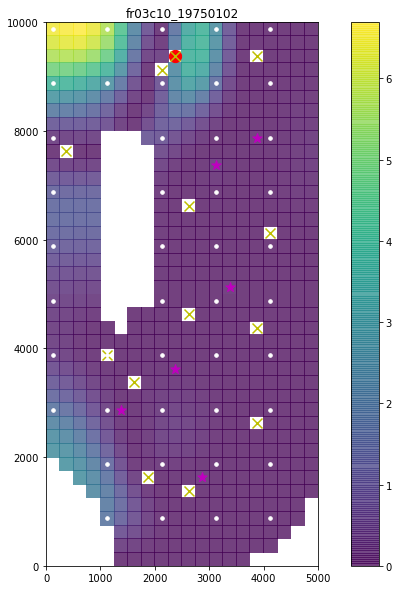

fr03c16_19750102


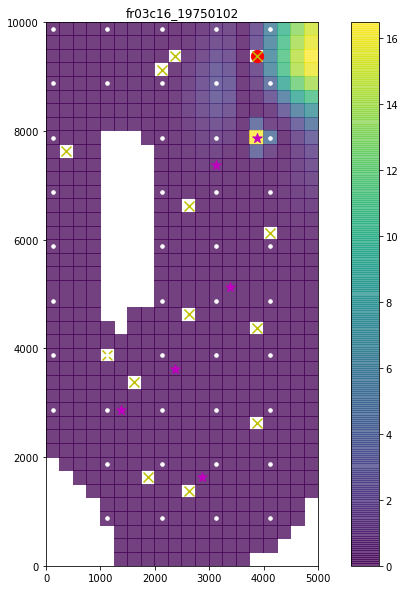

fr04c09_19750102


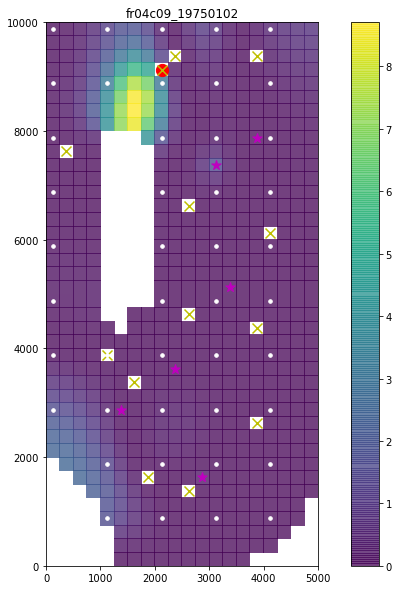

fr10c02_19750102


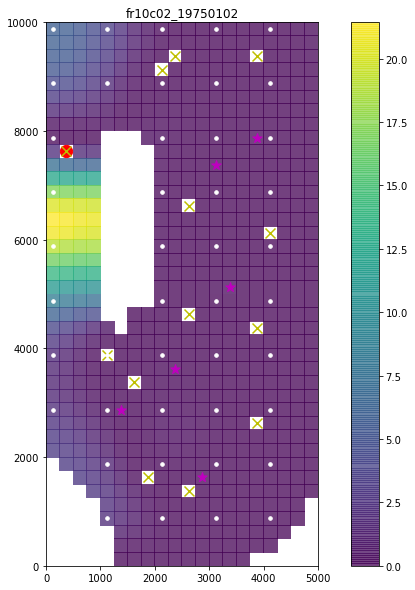

fr14c11_19750102


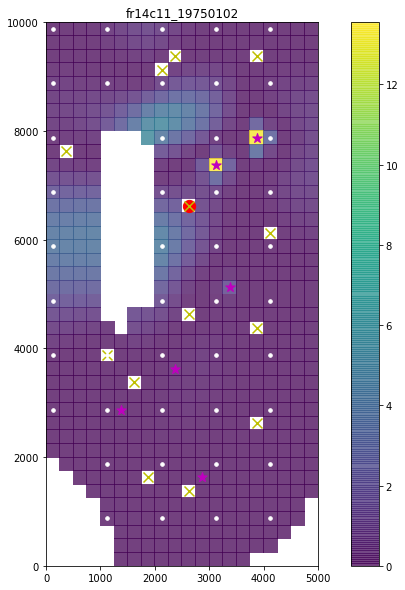

fr16c17_19750102


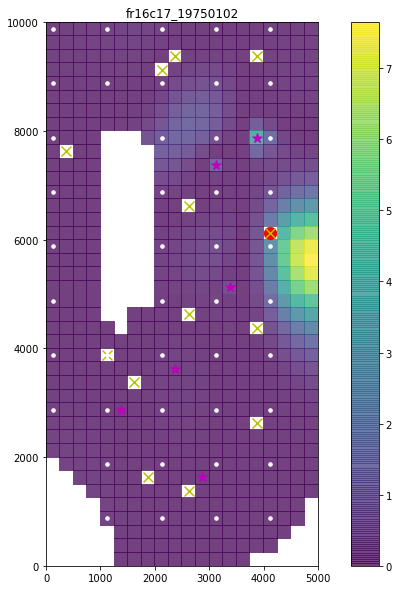

fr22c11_19750102


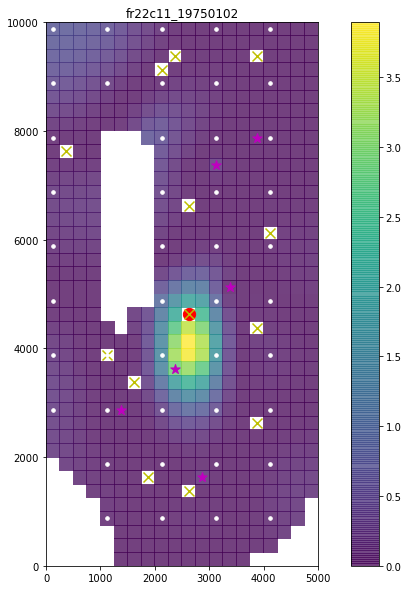

fr23c16_19750102


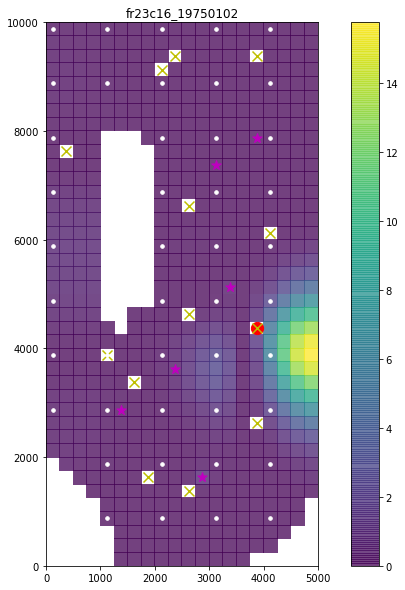

fr25c05_19750102


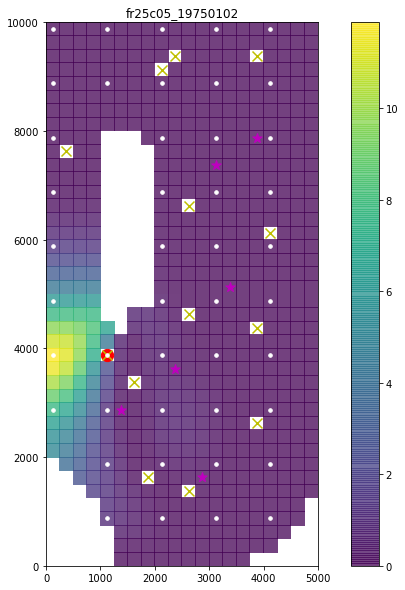

fr27c07_19750102


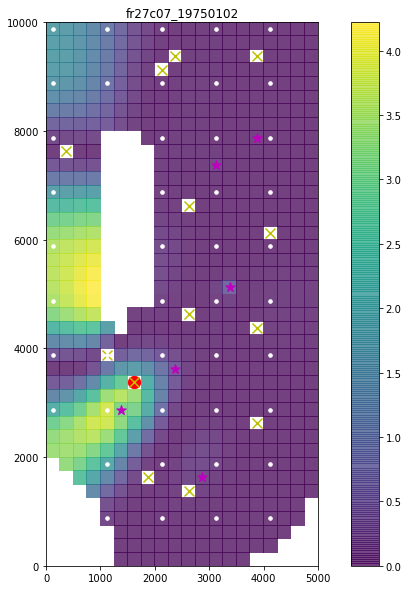

fr30c16_19750102


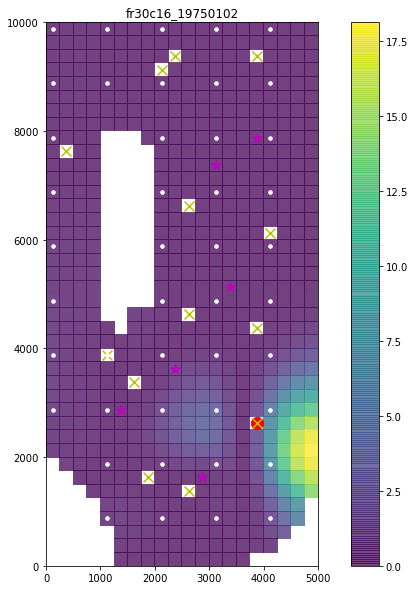

fr34c08_19750102


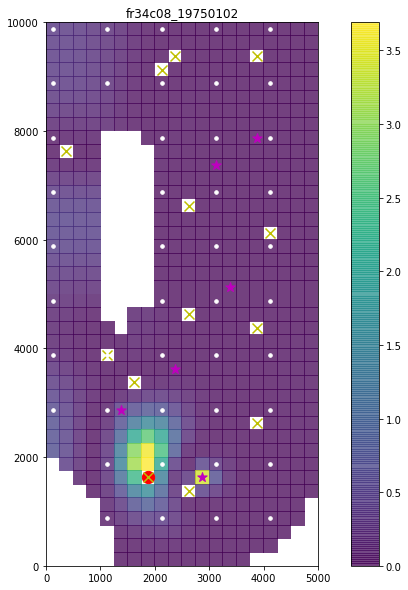

fr35c11_19750102


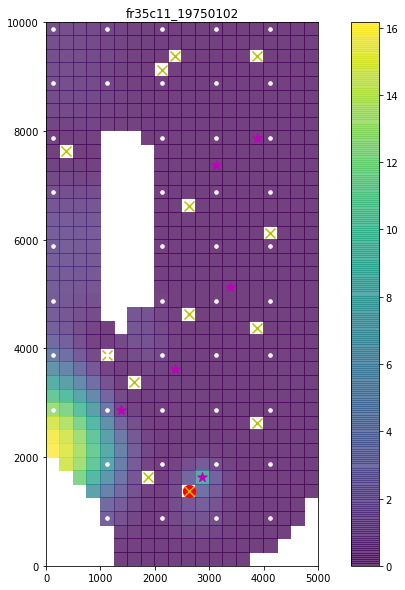

flx_river_l_19750102


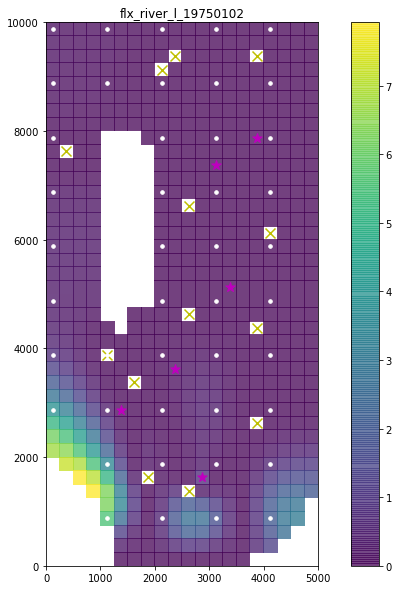

travel_time


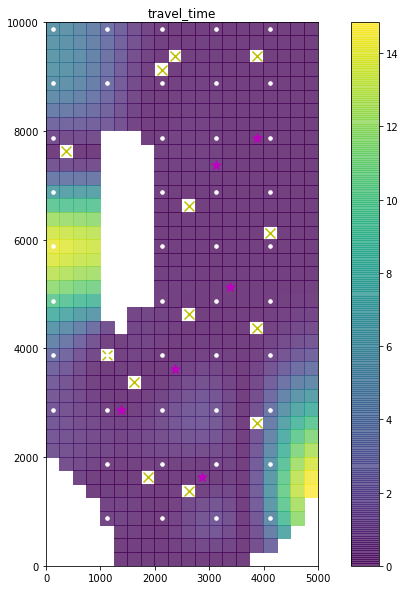

In [28]:
plot_added_worth(df_full)